# Conv1D + LSTM with Sunspot Dataset

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
tf.random.set_seed(51)
np.random.seed(51)

In [4]:
# df = pd.read_csv('datasets/sunspots.csv', 
df = pd.read_csv('sunspots.csv', 
                 index_col=0, parse_dates=['Date'])
df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


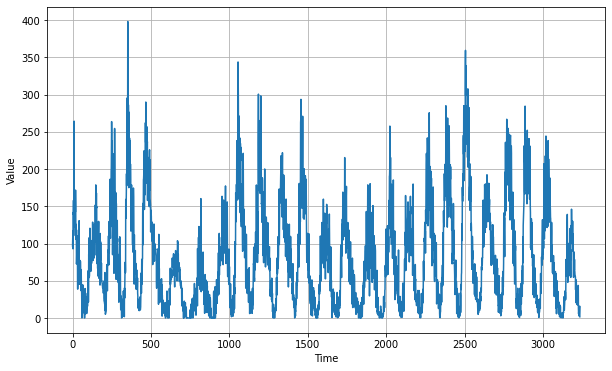

In [5]:
series = df['Monthly Mean Total Sunspot Number'].values
time = range(series.size)

plt.figure(figsize=(10, 6))
plt.plot(time, series)
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)

In [6]:
split_time = 3000
time_train = time[:split_time] 
x_train = series[:split_time] 
time_valid = time[split_time:] 
x_valid = series[split_time:] 

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer).map(lambda w: (w[:-1], w[1:]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w:w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, 
                           strides=1, padding="causal", activation="relu", 
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

model.compile(loss='mse', optimizer='adam', metrics=["mae"])

history = model.fit(train_set, epochs=500)

In [10]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
forecast = forecast[split_time - window_size:-1, -1, 0]
print(forecast.shape)
print(forecast)

(235,)
[126.461586  144.37227   110.49879   132.31377   103.690506  104.28613
 132.09302   115.26913    36.60998   137.93      183.4226    164.94344
 241.51172   141.27153   186.47478   165.06786   165.58981   191.11
 165.36884   141.96277   218.16347   183.70842   149.50719   179.77347
 116.690155   81.7728    122.622505  172.51225   211.97095   115.74232
 167.42436   102.0769    166.35565   113.22166   162.88084   117.819084
 200.15054   165.66164   160.80748   158.10953   179.33656   210.14767
 160.74966   194.46983   240.13223   248.49959   218.24329   174.71092
 201.53792   154.9237     90.20197   110.88172    76.288315   99.18835
 140.11693    69.16312    66.64065   117.71357   125.28949   102.222145
 127.63106   102.86144    73.11287    93.52789   103.86335   104.06779
  75.847824   83.41192    63.045395   58.94223    82.47087    67.59888
  49.807804   41.488354   42.66041    73.80183    50.355804   81.923386
  37.77658    46.954628   52.239548   71.07036    14.248448   55.82631

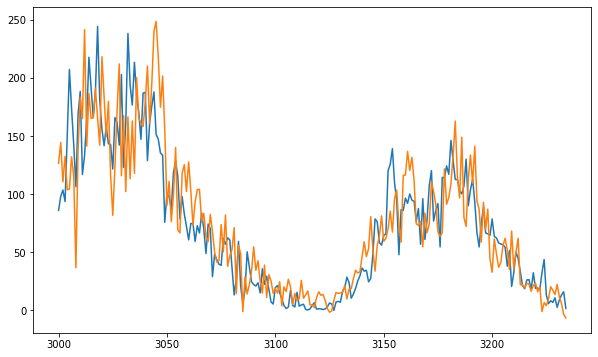

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid)
plt.plot(time_valid, forecast)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

22.908718